# Preparación de datos
## Importar bibliotecas

In [1]:
# Define the Imports 
try:
    import os
    import json
    import math
    import pandas as pd
    from datetime import date, time
    import numpy as np
    import pyarrow as pa
    import pyarrow.parquet as pq
   
    import dask  
    import dask.dataframe as dd
    import dask.array as da
    
    from dask import delayed
    from dask.distributed import Client, LocalCluster
    import dask.multiprocessing
    import warnings
    # Grádica
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.express as px
    from IPython.display import Image, display

    # Filtrar los warnings
    #warnings.filterwarnings("ignore", category=FutureWarning)
    # Restaurar el comportamiento predeterminado de los warnings después de ejecutar tu código
    #warnings.filterwarnings("default", category=FutureWarning)

except Exception as e:
    print("Some Modules are Missing : {} ".format(e))

In [2]:
# from os import listdir
# from os.path import isfile, join
#fhvhv_tripdata_2022-01.parquet
## https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page <br> oks
# Configurar el clúster de Dask
cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit='6GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 11.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52270,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 11.18 GiB
Comm: tcp://127.0.0.1:52281,Total threads: 1
Dashboard: http://127.0.0.1:52282/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:52273,


2024-04-05 01:47:58,152 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c09cbf9139a77bfba4cb68064c49b8af initialized by task ('shuffle-transfer-c09cbf9139a77bfba4cb68064c49b8af', 3) executed on worker tcp://127.0.0.1:52284
2024-04-05 01:47:58,765 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c09cbf9139a77bfba4cb68064c49b8af deactivated due to stimulus 'task-finished-1712299678.7639437'
2024-04-05 01:54:09,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d144b259ef7d3fb2caf121971812a18c initialized by task ('shuffle-transfer-d144b259ef7d3fb2caf121971812a18c', 3) executed on worker tcp://127.0.0.1:52284
2024-04-05 01:54:10,890 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d144b259ef7d3fb2caf121971812a18c deactivated due to stimulus 'task-finished-1712300050.8928142'
2024-04-05 01:54:16,723 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3fdb2aa6360d80f6db1bbd623f6df30d initialized by task ('shuffle-transfer-3fdb2aa6360d80

In [104]:
#client.close()
#cluster.close()


In [3]:
# Obtener la lista de archivos Parquet procesados en el directorio
directorio = "../datasets/processed/ffvh_analys/"
archivos_procesados = [os.path.join(directorio, f) for f in os.listdir(directorio) if f.endswith('.parquet')]

# Leer y concatenar los archivos Parquet procesados
df_procesado = None
for archivo in archivos_procesados:
    if df_procesado is None:
        df_procesado = dd.read_parquet(archivo, engine='pyarrow')
    else:
        df_procesado_nuevo = dd.read_parquet(archivo, engine='pyarrow')
        df_procesado = dd.concat([df_procesado, df_procesado_nuevo])

In [4]:
# Verificar el esquema del DataFrame concatenado
print("Esquema del DataFrame concatenado:")
print(df_procesado.dtypes)

Esquema del DataFrame concatenado:
hvfhs_license_num                     string[pyarrow]
dispatching_base_num                  string[pyarrow]
PULocationID                                    int64
DOLocationID                                    int64
trip_miles                                    float64
trip_time                                       int64
base_passenger_fare                           float64
pickup_datetime_fecha            date32[day][pyarrow]
pickup_datetime_hora_minuto           string[pyarrow]
dropoff_datetime_fecha           date32[day][pyarrow]
dropoff_datetime_hora_minuto          string[pyarrow]
request_datetime_fecha           date32[day][pyarrow]
request_datetime_hora_minuto          string[pyarrow]
on_scene_datetime_fecha          date32[day][pyarrow]
on_scene_datetime_hora_minuto         string[pyarrow]
duracion_viaje                                float64
duracion_atencion                             float64
total_amount                                  f

In [5]:
# Suponiendo que df_procesado es tu DataFrame de Dask
df_procesado = df_procesado.drop(columns=['pickup_datetime_hora_minuto',
                                           'dropoff_datetime_hora_minuto',
                                           'request_datetime_hora_minuto',
                                           'on_scene_datetime_hora_minuto',
                                           'dropoff_datetime_fecha',
                                           'request_datetime_fecha',
                                           'on_scene_datetime_fecha'])

In [6]:
# Verificar el esquema del DataFrame concatenado
print("Esquema del DataFrame concatenado:")
print(df_procesado.dtypes)

Esquema del DataFrame concatenado:
hvfhs_license_num             string[pyarrow]
dispatching_base_num          string[pyarrow]
PULocationID                            int64
DOLocationID                            int64
trip_miles                            float64
trip_time                               int64
base_passenger_fare                   float64
pickup_datetime_fecha    date32[day][pyarrow]
duracion_viaje                        float64
duracion_atencion                     float64
total_amount                          float64
dtype: object


In [7]:
# Verificar valores nulos y sumarlos para cada columna
#null_counts = df_procesado.isnull().sum().compute()
#null_counts

In [8]:
type(df_procesado)  
#'pickup_datetime_hora_minuto','dropoff_datetime_hora_minuto','request_datetime_hora_minuto', 'on_scene_datetime_hora_minuto', 'dropoff_datetime_fecha', 
# 'request_datetime_fecha','on_scene_datetime_fecha', 

dask_expr._collection.DataFrame

In [9]:
df_procesado.head()

,hvfhs_license_num,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,pickup_datetime_fecha,duracion_viaje,duracion_atencion,total_amount
0,HV0003,B03404,170,161,1.18,664,24.90,2022-01-01,664.0,9.0,53.64
1,HV0003,B03404,237,161,0.82,460,11.97,2022-01-01,460.0,161.0,28.46
2,HV0003,B03404,237,161,1.18,595,29.82,2022-01-01,595.0,824.0,59.41
3,HV0003,B03404,262,229,1.65,303,7.91,2022-01-01,303.0,92.0,17.90
4,HV0003,B03404,229,141,1.65,461,9.44,2022-01-01,461.0,16.0,20.75


In [5]:
# Definir una función auxiliar para verificar si una columna es numérica
def is_numeric_dtype(column):
    return column.dtype in [int, float,'int64']

# Obtener solo las columnas numéricas
numeric_columns = [col_name for col_name in df_procesado.columns if is_numeric_dtype(df_procesado[col_name])]

# Convertir la selección de columnas en una operación lazy
lazy_select = df_procesado[numeric_columns]

# Calcular estadísticas descriptivas solo para las columnas numéricas de manera lazy
lazy_stats = lazy_select.describe()

# Ejecutar la operación lazy para obtener los resultados
#stats_result = lazy_stats.compute()

In [6]:
lazy_stats

,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount
npartitions=1,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...


In [7]:
# Formatear el DataFrame de estadísticas descriptivas para hacerlo más legible
formatted_stats_df = lazy_stats.compute().applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)

# Imprimir el DataFrame formateado
formatted_stats_df

C:\Users\ozi\AppData\Local\Temp\ipykernel_1404\791640754.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_stats_df = lazy_stats.compute().applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)


,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount
count,"10,669,658.00","10,669,658.00","10,669,658.00","10,669,658.00","10,669,658.00","10,669,658.00","10,669,658.00","10,669,658.00"
mean,138.84,142.06,4.54,"1,008.50",19.56,"1,008.44",192.01,40.57
std,75.60,77.87,5.21,686.18,15.42,686.10,159.67,31.74
min,2.00,1.00,0.00,1.00,-348.61,1.00,0.00,-40.67
25%,75.00,76.00,1.52,563.00,11.06,563.00,107.00,22.11
50%,141.00,143.00,2.80,884.00,17.33,884.00,187.00,34.69
75%,212.00,220.00,5.77,"1,379.00",26.31,"1,379.00",310.00,54.21
max,265.00,265.00,440.71,"147,918.00","4,995.96","147,918.00","33,013.00","10,293.29"


In [8]:
def obtener_valores_unicos(df_dask, columna):
    # Seleccionar la columna especificada
    columna_serie = df_dask[columna]
    
    # Obtener los valores únicos de la columna
    valores_unicos = columna_serie.unique().compute()
 
    return valores_unicos

In [9]:
# Usar la función para obtener los valores únicos de la columna 'hvfhs_license_num'
valores_unicos_hvfhs_license_num = obtener_valores_unicos(df_procesado, 'hvfhs_license_num')
# Imprimir los valores únicos
print(valores_unicos_hvfhs_license_num)

0    HV0003
1    HV0005
Name: hvfhs_license_num, dtype: string


In [10]:
# Usar la función para obtener los valores únicos de la columna 'hvfhs_license_num'
valores_unicos_dispatching_base_num = obtener_valores_unicos(df_procesado, 'dispatching_base_num')
# Imprimir los valores únicos
valores_unicos_dispatching_base_num

0    B02395
1    B02878
2    B02872
3    B02765
4    B02870
5    B02880
6    B02887
7    B02875
0    B02867
1    B02879
2    B02864
3    B02882
4    B02876
5    B02877
6    B02682
7    B02835
0    B03404
1    B02889
2    B02512
3    B02869
4    B02884
0    B02764
1    B03406
2    B02617
3    B02888
4    B02866
5    B02871
6    B02883
Name: dispatching_base_num, dtype: string

In [7]:
# Convertir el DataFrame de Dask a un DataFrame de pandas
df_pandas = df_procesado.compute()

# Definir el tamaño de la muestra
sample_fraction = 0.1  # Por ejemplo, tomemos el 10% de los datos

# Obtener una muestra del DataFrame original
df_muestra = df_procesado.sample(frac=sample_fraction, random_state=42)

# Convertir el DataFrame de Dask a un DataFrame de Pandas
df_muestra_pd = df_muestra.compute()

# Convertir el DataFrame de pandas a un DataFrame de Dask
ddf_muestra = dd.from_pandas(df_muestra_pd, npartitions=4)


In [8]:
type(ddf_muestra)

dask_expr._collection.DataFrame

In [9]:
ddf_muestra.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,hvfhs_license_num,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,pickup_datetime_fecha,duracion_viaje,duracion_atencion,total_amount
4,HV0003,B03404,229,141,1.65,461,9.44,2022-01-01,461.0,16.0,20.75
7,HV0003,B03404,151,75,2.77,843,14.41,2022-01-01,843.0,37.0,31.59
18,HV0003,B03404,223,179,1.69,637,9.81,2022-01-01,637.0,261.0,20.52
19,HV0003,B03404,179,7,0.87,472,10.53,2022-01-01,472.0,527.0,21.00
26,HV0003,B03404,158,261,2.25,579,13.08,2022-01-01,579.0,385.0,26.04


C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\base.py:1462: UserWarning:

Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.



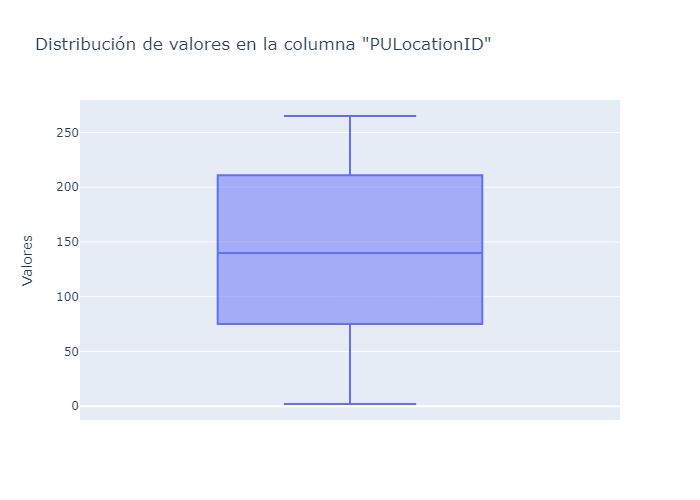

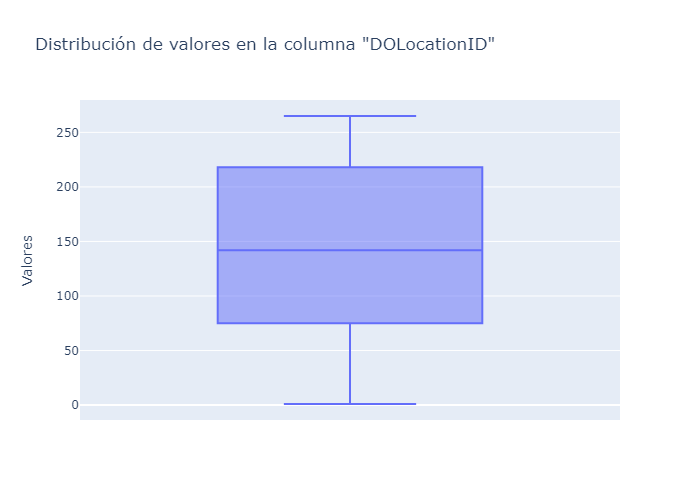

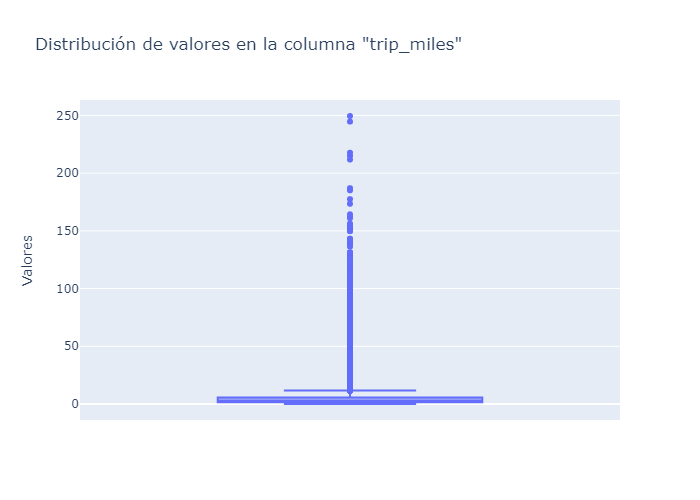

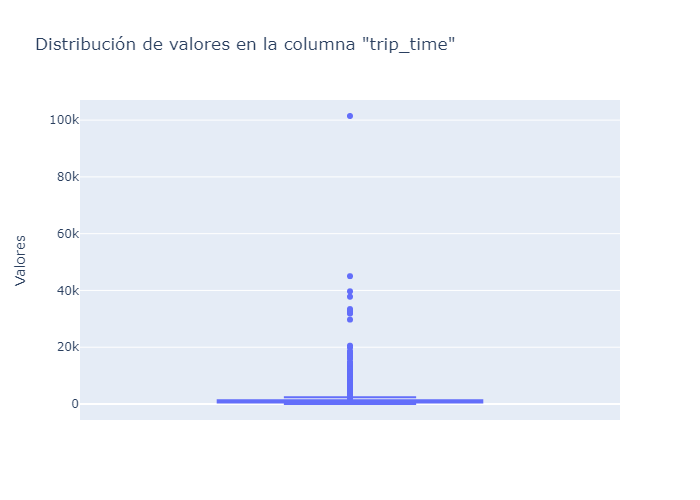

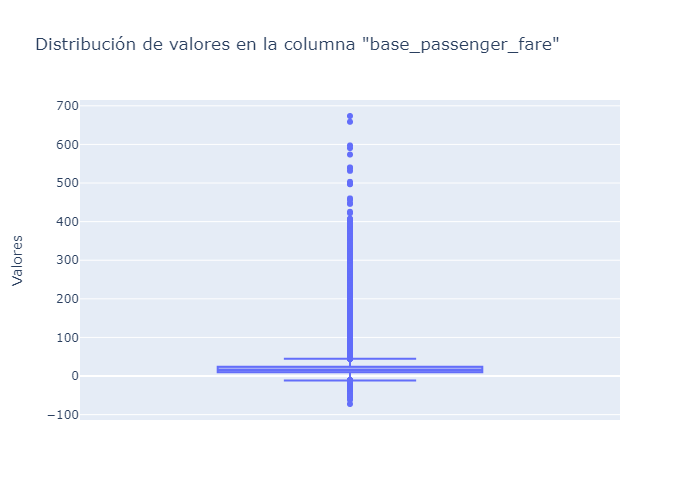

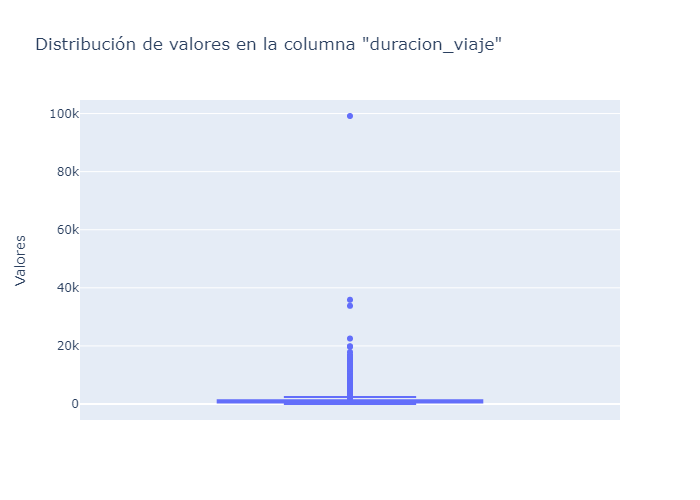

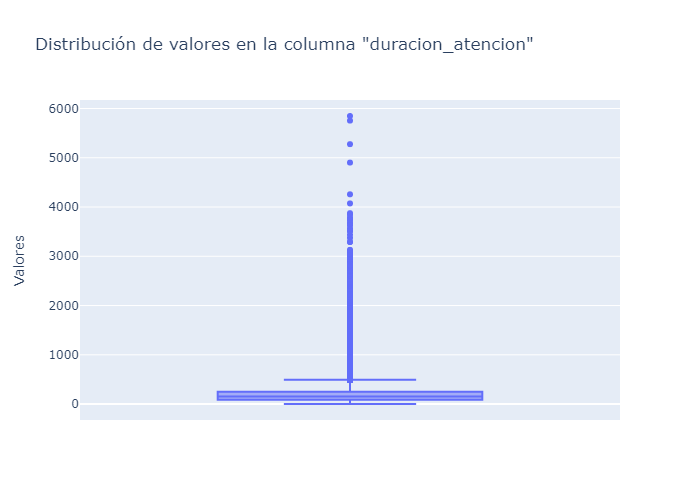

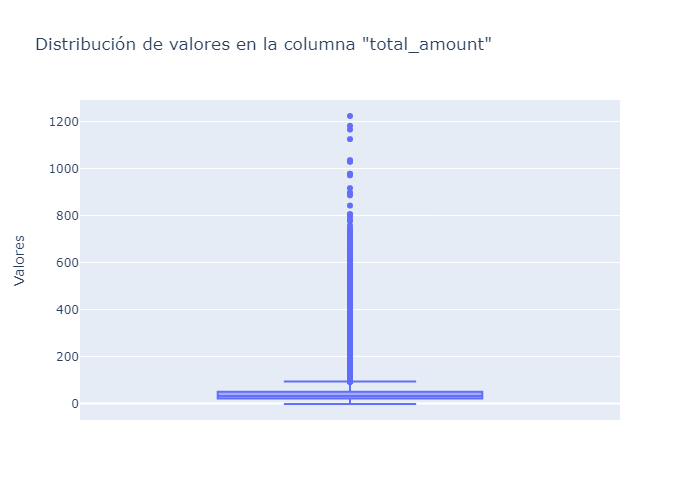

In [10]:
import os

@dask.delayed
def create_boxplot(dataframe, column, filename_prefix, theme='plotly'):
    image_path = f'../vis/{filename_prefix}_{column}.png'

    # Verificar si la imagen ya existe
    if os.path.exists(image_path):
        print(f"La imagen para la columna '{column}' ya existe, no se generará nuevamente.")
        return image_path

    # Si la imagen no existe, generar el gráfico
    fig = px.box(dataframe, y=column, labels={column: 'Valores'},
                 title=f'Distribución de valores en la columna "{column}"',
                 template=theme)
    fig.write_image(image_path)
    return image_path

def boxplot_visualization(dataframe, columns, filename_prefix, theme='plotly'):
    """
    Crea gráficos de boxplot interactivos para visualizar la distribución de variables numéricas específicas en un DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): El DataFrame que contiene los datos.
    - columns (list): Lista de nombres de columnas numéricas que se desean visualizar.
    - filename_prefix (str): El prefijo para el nombre del archivo de imagen donde se guardarán los gráficos.
    - theme (str, optional): El tema del gráfico. Puede ser 'plotly', 'ggplot2', 'seaborn', 'simple_white', entre otros.
      Por defecto, es 'plotly'.

    Returns:
    None
    """

    tasks = []
    for column in columns:
        task = create_boxplot(dataframe, column, filename_prefix, theme)
        tasks.append(task)

    image_paths = dask.compute(*tasks, scheduler='threads')

    for image_path in image_paths:
        display(Image(filename=image_path))

# Utilizar la función para plotear las columnas numéricas específicas del DataFrame
boxplot_visualization(ddf_muestra, ddf_muestra.select_dtypes(include=['number']).columns, 'boxplot_selected_variables')

In [32]:
# 5. Cerrar el clúster de Dask
#client.close()
#cluster.close()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


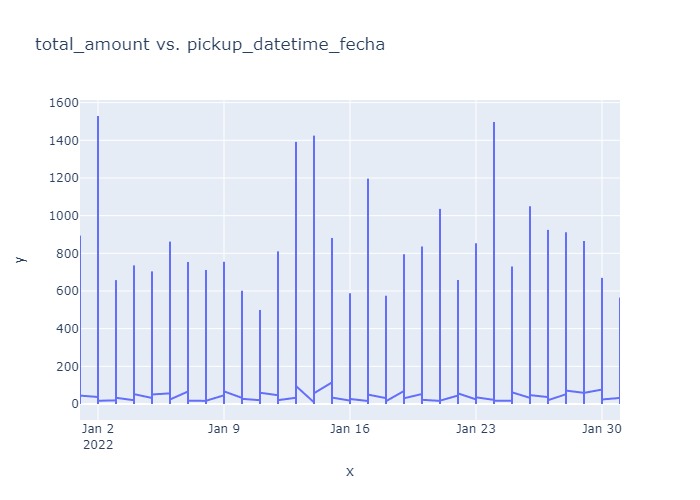

In [17]:
@dask.delayed
def create_temporal_plot(dataframe, fecha_column, y_column, filename_prefix, theme='plotly'):
    image_path = f'../vis/{filename_prefix}_temporal.png'

    # Verificar si la imagen ya existe
    if os.path.exists(image_path):
        print(f"La imagen temporal para {y_column} ya existe, no se generará nuevamente.")
        return image_path

    # Convertir la columna de fecha a un tipo de dato compatible
    dataframe[fecha_column] = pd.to_datetime(dataframe[fecha_column])

    # Crear figura de Plotly
    fig = px.line(x=dataframe[fecha_column], y=dataframe[y_column],
                  labels={fecha_column: 'Fecha', y_column: 'Valor'},
                  title=f'{y_column} vs. {fecha_column}', template=theme)

    fig.write_image(image_path)
    return image_path

def visualize_temporal_data(dataframe, fecha_column, y_column, filename_prefix, theme='plotly'):
    """
    Crea una visualización temporal para un DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): El DataFrame que contiene los datos.
    - fecha_column (str): El nombre de la columna que contiene las fechas.
    - y_column (str): El nombre de la columna que contiene los datos a graficar en el eje y.
    - filename_prefix (str): El prefijo para el nombre del archivo de imagen donde se guardará el gráfico temporal.
    - theme (str, optional): El tema del gráfico. Puede ser 'plotly', 'ggplot2', 'seaborn', 'simple_white', entre otros.
      Por defecto, es 'plotly'.

    Returns:
    None
    """

    task = create_temporal_plot(dataframe, fecha_column, y_column, filename_prefix, theme)
    image_path = task.compute(scheduler='threads')
    display(Image(filename=image_path))

# Ejemplo de uso para crear un gráfico temporal
visualize_temporal_data(ddf_muestra, 'pickup_datetime_fecha', 'total_amount', 'grafico_temporal')

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\base.py:1462: UserWarning:

Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.



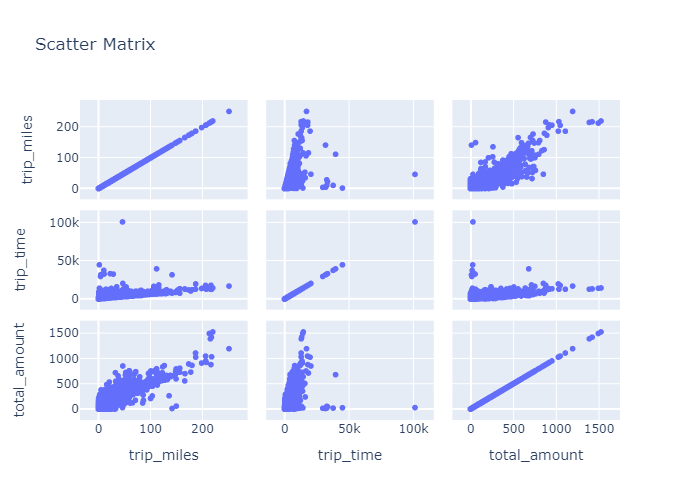

In [12]:
@dask.delayed
def create_visualization(dataframe, visualization_type, columns, filename_prefix, theme='plotly'):
    image_path = f'../vis/{filename_prefix}_{visualization_type}.png'

    # Verificar si la imagen ya existe
    if os.path.exists(image_path):
        print(f"La imagen para {visualization_type} con columnas {', '.join(columns)} ya existe, no se generará nuevamente.")
        return image_path

    if visualization_type == 'boxplot':
        fig = px.box(dataframe, y=columns, labels={col: 'Valores' for col in columns},
                     title=f'Distribución de valores en las columnas {", ".join(columns)}',
                     template=theme)
    elif visualization_type == 'scatter_matrix':
        fig = px.scatter_matrix(dataframe[columns], dimensions=columns, title='Scatter Matrix',
                                template=theme)
    else:
        raise ValueError("Tipo de visualización no válido. Debe ser 'boxplot' o 'scatter_matrix'.")

    fig.write_image(image_path)
    return image_path

def visualize_data(dataframe, visualization_type, columns, filename_prefix, theme='plotly'):
    """
    Crea visualizaciones interactivas para un DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): El DataFrame que contiene los datos.
    - visualization_type (str): El tipo de visualización. Puede ser 'boxplot' o 'scatter_matrix'.
    - columns (list): Lista de nombres de columnas para visualizar.
    - filename_prefix (str): El prefijo para el nombre del archivo de imagen donde se guardarán los gráficos.
    - theme (str, optional): El tema del gráfico. Puede ser 'plotly', 'ggplot2', 'seaborn', 'simple_white', entre otros.
      Por defecto, es 'plotly'.

    Returns:
    None
    """

    tasks = []
    for col_set in columns:
        task = create_visualization(dataframe, visualization_type, col_set, filename_prefix, theme)
        tasks.append(task)

    image_paths = dask.compute(*tasks, scheduler='threads')

    for image_path in image_paths:
        display(Image(filename=image_path))

# Ejemplo de uso para crear un scatter matrix
visualize_data(ddf_muestra, 'scatter_matrix', [['trip_miles', 'trip_time', 'total_amount']], 'scatter_matrix_visualization')


In [18]:
ddf_muestra.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning:

Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.



,hvfhs_license_num,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,pickup_datetime_fecha,duracion_viaje,duracion_atencion,total_amount
4,HV0003,B03404,229,141,1.65,461,9.44,2022-01-01,461.0,16.0,20.75
7,HV0003,B03404,151,75,2.77,843,14.41,2022-01-01,843.0,37.0,31.59
18,HV0003,B03404,223,179,1.69,637,9.81,2022-01-01,637.0,261.0,20.52
19,HV0003,B03404,179,7,0.87,472,10.53,2022-01-01,472.0,527.0,21.00
26,HV0003,B03404,158,261,2.25,579,13.08,2022-01-01,579.0,385.0,26.04


In [19]:
# Verificar el esquema del DataFrame concatenado
print("Esquema del DataFrame concatenado:")
print(ddf_muestra.dtypes)

Esquema del DataFrame concatenado:
hvfhs_license_num             string[pyarrow]
dispatching_base_num          string[pyarrow]
PULocationID                            int64
DOLocationID                            int64
trip_miles                            float64
trip_time                               int64
base_passenger_fare                   float64
pickup_datetime_fecha    date32[day][pyarrow]
duracion_viaje                        float64
duracion_atencion                     float64
total_amount                          float64
dtype: object


In [9]:
# Convertir duracion_atencion de float64 a int64
ddf_muestra['duracion_atencion'] = ddf_muestra['duracion_atencion'].astype('int64')

In [10]:
def preprocess_categorical_columns(ddf, categorical_columns):
    # Obtener el DataFrame con las columnas categóricas
    categorical_df = ddf[categorical_columns]
    
    # Convertir las columnas categóricas a tipo categórico
    categorical_df = categorical_df.categorize()
    
    # Aplicar one-hot encoding
    onehot_df = dd.get_dummies(categorical_df, drop_first=True)
    
    # Asignar 1 si es verdadero y 0 si es falso en las columnas dummy
    onehot_df = onehot_df.astype(int)
    
    # Eliminar la columna original de hvfhs_license_num
    ddf = ddf.drop(columns=categorical_columns)
    
    # Concatenar el DataFrame original con las nuevas columnas codificadas
    result_df = dd.concat([ddf, onehot_df], axis=1)
    return result_df

# Lista de columnas categóricas
categorical_columns = ['hvfhs_license_num']

# Preprocesamiento de columnas categóricas
ddf_resultante = preprocess_categorical_columns(ddf_muestra, categorical_columns)

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 22.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [11]:
ddf_resultante.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,pickup_datetime_fecha,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
4,B03404,229,141,1.65,461,9.44,2022-01-01,461.0,16,20.75,0
7,B03404,151,75,2.77,843,14.41,2022-01-01,843.0,37,31.59,0
18,B03404,223,179,1.69,637,9.81,2022-01-01,637.0,261,20.52,0
19,B03404,179,7,0.87,472,10.53,2022-01-01,472.0,527,21.00,0
26,B03404,158,261,2.25,579,13.08,2022-01-01,579.0,385,26.04,0


In [12]:
def encode_categorical_column_as_codes(ddf, column_name):
    """
    Convierte una columna categórica en códigos numéricos.

    Parameters:
    ddf (dask.dataframe.DataFrame): DataFrame dask.
    column_name (str): Nombre de la columna categórica a codificar.

    Returns:
    dask.dataframe.DataFrame: DataFrame con la columna codificada.
    """
    # Convertir la columna a categoría conocida
    ddf[column_name] = ddf[column_name].astype('category')
    
    # Asegurarse de que las categorías sean conocidas
    ddf[column_name] = ddf[column_name].cat.as_known()
    
    # Obtener los códigos de las categorías
    ddf[column_name] = ddf[column_name].cat.codes
    
    return ddf

In [13]:
# Nombre de la columna categórica a codificar
column_name = 'dispatching_base_num'

# Aplicar la función para codificar la columna
ddf_resultante = encode_categorical_column_as_codes(ddf_resultante, column_name)

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 22.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [14]:
# Eliminar la columna original de hvfhs_license_num
ddf_resultante = ddf_resultante.drop(columns='pickup_datetime_fecha')

In [15]:
ddf_resultante.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
4,20,229,141,1.65,461,9.44,461.0,16,20.75,0
7,20,151,75,2.77,843,14.41,843.0,37,31.59,0
18,20,223,179,1.69,637,9.81,637.0,261,20.52,0
19,20,179,7,0.87,472,10.53,472.0,527,21.00,0
26,20,158,261,2.25,579,13.08,579.0,385,26.04,0


In [16]:
ddf_resultante.dtypes

dispatching_base_num           int8
PULocationID                  int64
DOLocationID                  int64
trip_miles                  float64
trip_time                     int64
base_passenger_fare         float64
duracion_viaje              float64
duracion_atencion             int64
total_amount                float64
hvfhs_license_num_HV0005      int32
dtype: object

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Axes: >

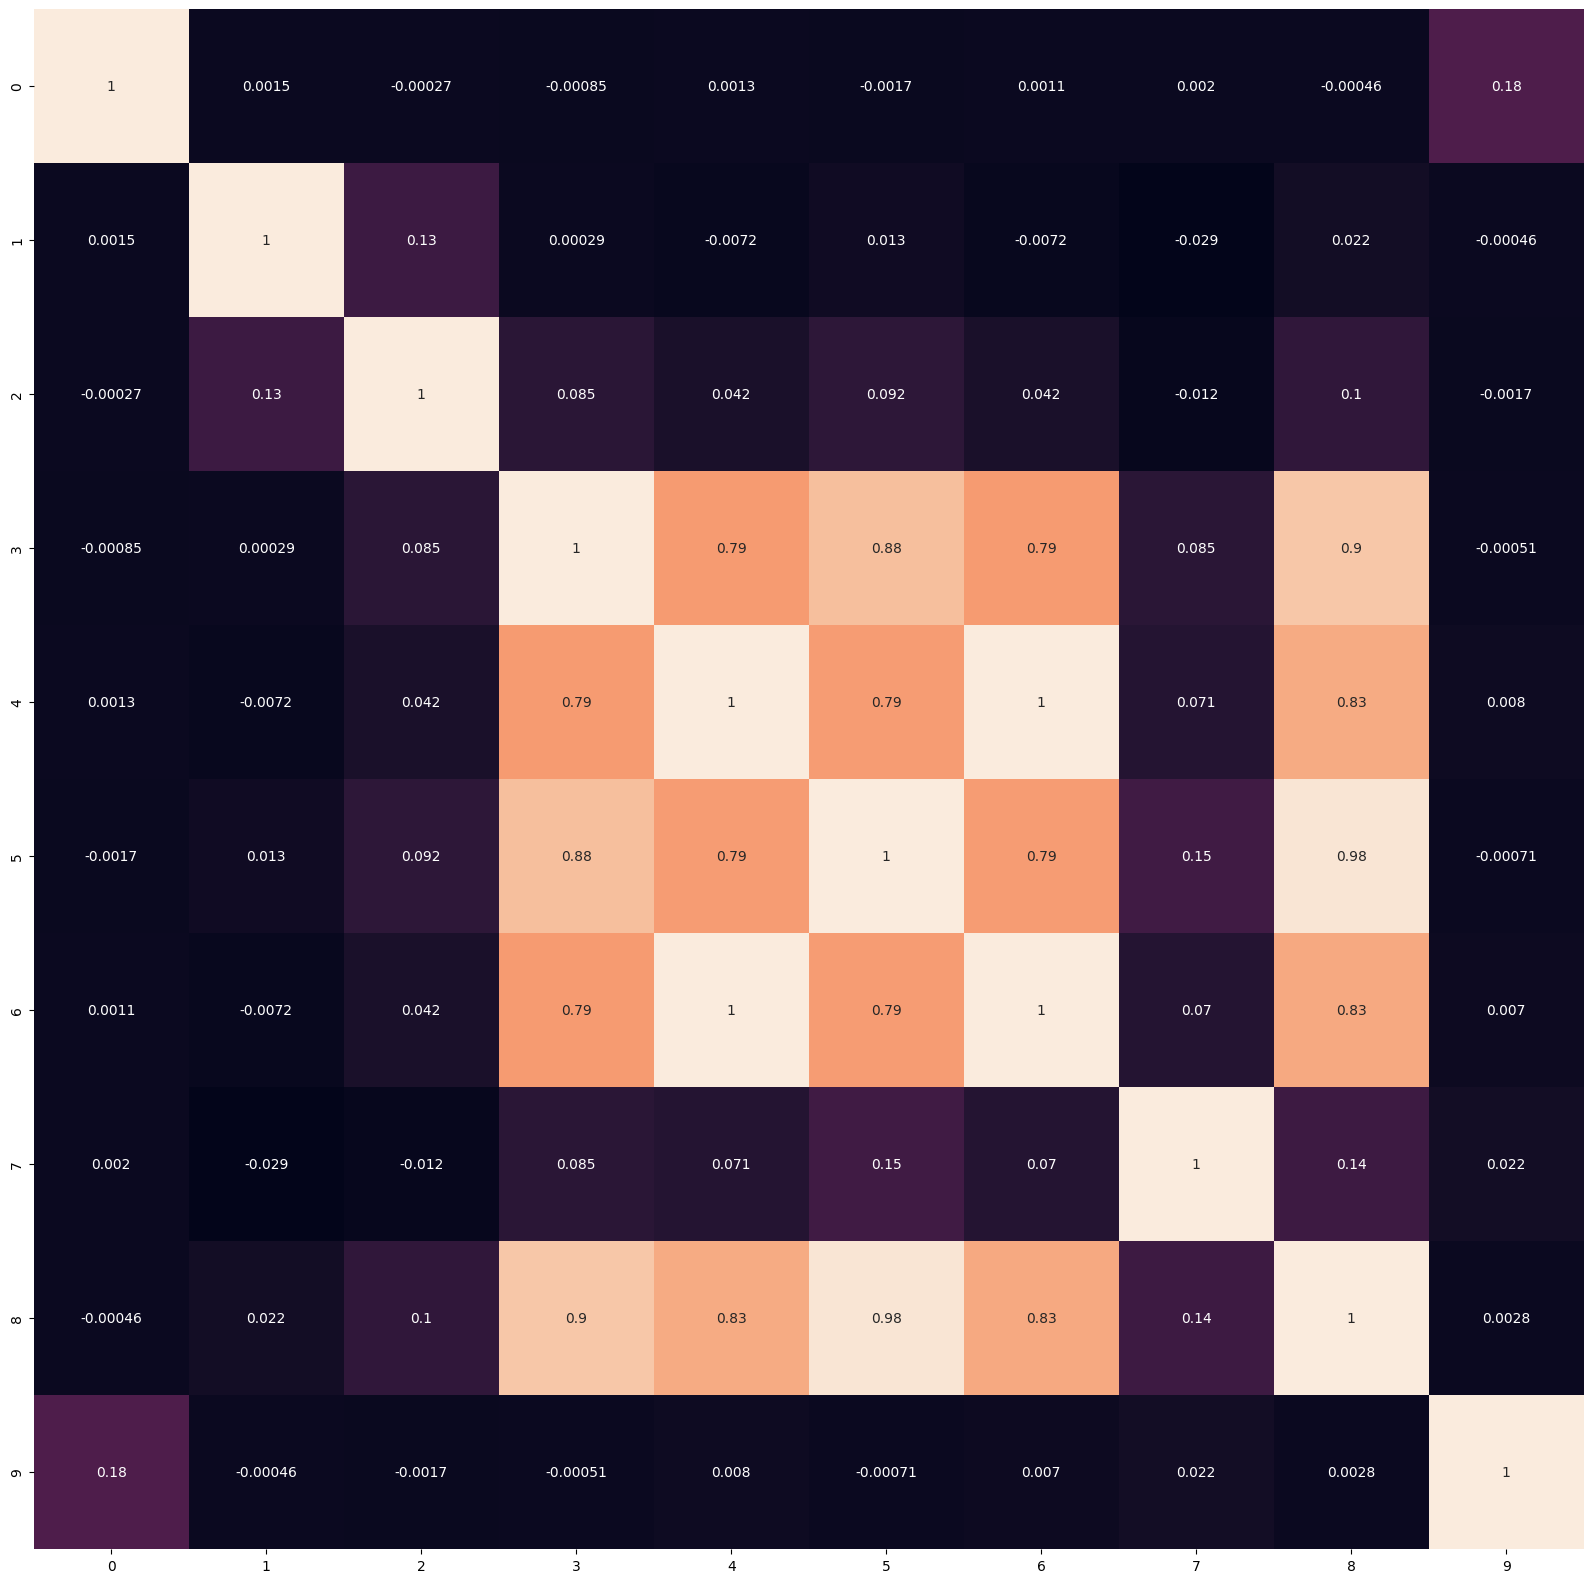

In [14]:
plt.figure(figsize = (20, 20))
corr_matrix = ddf_resultante.iloc[:, :13].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [17]:
# Modelado y Procesamiento
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import dask_ml
import dask_ml.preprocessing
import dask.array as da

In [22]:
# Escalamos los datos
scaler = StandardScaler()
result_df_scaled = scaler.fit_transform(ddf_resultante)

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
result_df_scaled.shape

(1066967, 10)

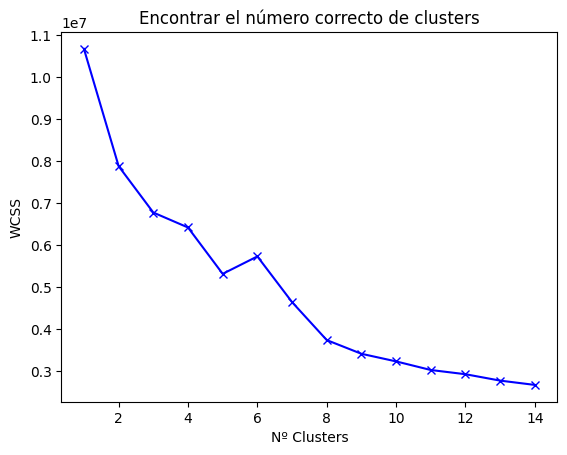

In [24]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(result_df_scaled)
  scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
# Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(result_df_scaled)
labels = kmeans.labels_

In [26]:
labels

array([0, 2, 0, ..., 2, 0, 2])

In [27]:
kmeans.cluster_centers_.shape

(5, 10)

In [24]:
# Echemos un vistazo a los centros de los clústeres
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [ddf_resultante.columns])
cluster_centers

,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
0,0.019277,0.835112,0.305290,-0.411640,-0.457902,-0.408180,-0.457906,-0.130295,-0.416264,-0.005905
1,0.023669,0.006435,0.292915,3.017571,2.701279,3.033069,2.700449,0.347445,3.113092,0.007092
2,0.019408,-0.885905,-0.380934,-0.418777,-0.458125,-0.431722,-0.458132,-0.022481,-0.459551,-0.002011
3,-41.428927,-0.088696,0.005649,0.052228,0.022823,0.098564,0.022904,0.140885,0.068242,-0.012661
4,0.022180,-0.014823,0.023400,0.696537,0.889261,0.707167,0.889437,0.173570,0.746011,0.011039


In [26]:
# Para entender lo que significan estos números, realicemos una transformación inversa
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [ddf_resultante.columns])
cluster_centers

,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
0,26.882924,15404.063659,13056.407319,17.056289,4.820844e+05,223.881429,4.819937e+05,27528.359617,907.852668,0.000161
1,26.883445,10670.486004,12981.398839,111.183599,2.013723e+06,1035.749494,2.012773e+06,39671.117063,4432.664003,0.000163
2,26.882939,5573.256697,8896.944753,16.860389,4.819762e+05,218.327422,4.818841e+05,30268.687540,864.620892,0.000162
3,21.966961,10127.078029,11240.173334,29.788866,7.151502e+05,343.433692,7.150309e+05,34420.964698,1391.734397,0.000160
4,26.883268,10549.057774,11347.767411,47.474277,1.135218e+06,487.016983,1.135018e+06,35251.713717,2068.631039,0.000164


##### Interpretación de los clusters:

`Cluster 0 (Alto Riesgo):`
- Este cluster muestra un alto promedio de trip_miles (~64.20) y base_passenger_fare (~977,777).
- Los viajes en este cluster tienden a tener una duración relativamente larga (promedio duracion_viaje ~591.98) y duracion_atencion (~965.57).
- La mayoría de los viajes en este cluster parecen ser realizados por bases de despacho específicas (dispatching_base_num).
- No parece haber una relación clara entre la presencia de la licencia HVFHS y este cluster.

`Cluster 1 (Moderado Riesgo y Alta Cantidad de Víctimas):`
- Este cluster exhibe un promedio de trip_miles y base_passenger_fare moderadamente altos (~75.37 y ~1,263,456 respectivamente).
- Los viajes en este cluster tienen una duración media (promedio duracion_viaje ~417.22) y duracion_atencion (~1,217.92).
- Puede observarse una distribución equilibrada de la licencia HVFHS en este cluster.

`Cluster 2 (Bajo Riesgo y Cantidad Moderada de Víctimas):`
- Este cluster tiene un promedio de trip_miles y base_passenger_fare relativamente bajos (~26.88 y ~460,150 respectivamente).
- Los viajes en este cluster tienen una duración y duracion_atencion más cortas en comparación con otros clusters (promedio duracion_viaje ~223.88 y duracion_atencion ~907.85).
- La presencia de la licencia HVFHS es baja en este cluster.

`Cluster 3 (Moderado Riesgo con Alta Cantidad de Víctimas):`
- Los viajes en este cluster tienen un promedio de trip_miles y base_passenger_fare moderadamente altos (~69.58 y ~1,145,931 respectivamente).
- La duración de los viajes en este cluster es moderada (promedio duracion_viaje ~369.61) y duracion_atencion (~1,257.10).
- La licencia HVFHS está presente en una cantidad significativa de viajes en este cluster.

`Cluster 4 (Bajo Riesgo y Cantidad Baja de Víctimas):`
- Este cluster muestra un bajo promedio de trip_miles y base_passenger_fare (~20.28 y ~356,752 respectivamente).
- Los viajes en este cluster tienen una duración y duracion_atencion más cortas en comparación con otros clusters (promedio duracion_viaje ~212.25 y duracion_atencion ~850.20).
- La presencia de la licencia HVFHS es baja en este cluster.

Esta interpretación proporciona una visión general de las características y patrones identificados en cada cluster. Es importante tener en cuenta que estos resultados son interpretaciones generales y pueden variar dependiendo de la naturaleza específica de tus datos y del algoritmo de clustering utilizado.

In [28]:
labels.shape # Etiquetas del clúster asociado a cada observación

(1066967,)

In [29]:
labels.max()

4

In [30]:
labels.min()

0

In [30]:
y_kmeans = kmeans.fit_predict(result_df_scaled)
y_kmeans

array([3, 0, 3, ..., 0, 3, 0])

In [31]:
y_kmeans.shape

(1066967,)

In [31]:
def add_cluster_label(ddf_resultante, labels):
    # Convertir el DataFrame de Dask a Pandas para agregar la columna de clúster
    pd_df_resultante = ddf_resultante.compute()

    # Agregar la columna de clúster
    pd_df_resultante['cluster'] = labels

    # Convertir el DataFrame de Pandas resultante de nuevo a un DataFrame de Dask
    ddf_result_with_cluster = dd.from_pandas(pd_df_resultante, npartitions=ddf_resultante.npartitions)

    return ddf_result_with_cluster

In [32]:
# Llamar a la función y obtener el DataFrame de Dask resultante
ddf_result_with_cluster = add_cluster_label(ddf_resultante, labels)

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [33]:
ddf_resultante.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
4,20,229,141,1.65,461,9.44,461.0,16,20.75,0
7,20,151,75,2.77,843,14.41,843.0,37,31.59,0
18,20,223,179,1.69,637,9.81,637.0,261,20.52,0
19,20,179,7,0.87,472,10.53,472.0,527,21.00,0
26,20,158,261,2.25,579,13.08,579.0,385,26.04,0


In [34]:
ddf_result_with_cluster.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 20.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005,cluster
4,20,229,141,1.65,461,9.44,461.0,16,20.75,0,0
7,20,151,75,2.77,843,14.41,843.0,37,31.59,0,2
18,20,223,179,1.69,637,9.81,637.0,261,20.52,0,0
19,20,179,7,0.87,472,10.53,472.0,527,21.00,0,2
26,20,158,261,2.25,579,13.08,579.0,385,26.04,0,0


In [ ]:
ddf_result_with_cluster.shape

In [42]:
ddf_result_with_cluster.dtypes

dispatching_base_num           int8
PULocationID                  int64
DOLocationID                  int64
trip_miles                  float64
trip_time                     int64
base_passenger_fare         float64
duracion_viaje              float64
duracion_atencion             int64
total_amount                float64
hvfhs_license_num_HV0005      int32
cluster                       int32
dtype: object

In [73]:
# Verificar el número de particiones del DataFrame original
num_partitions_original = ddf_resultante.npartitions
print("Número de particiones del DataFrame original:", num_partitions_original)

# Verificar el número de particiones de labels_dask
num_partitions_labels = labels_dask.npartitions
print("Número de particiones de labels_dask:", num_partitions_labels)
print("Número de particiones de labels_dask después del reajuste:", labels_dask.npartitions)


Número de particiones del DataFrame original: 4
Número de particiones de labels_dask: 266742
Número de particiones de labels_dask después del reajuste: 266742


C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

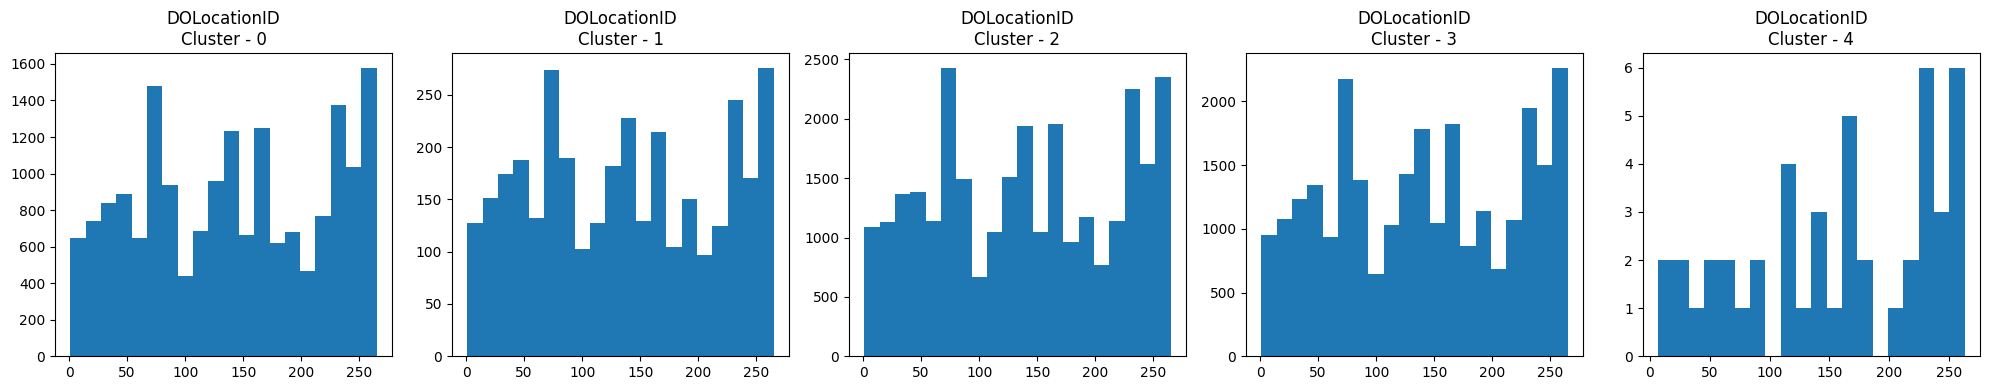

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

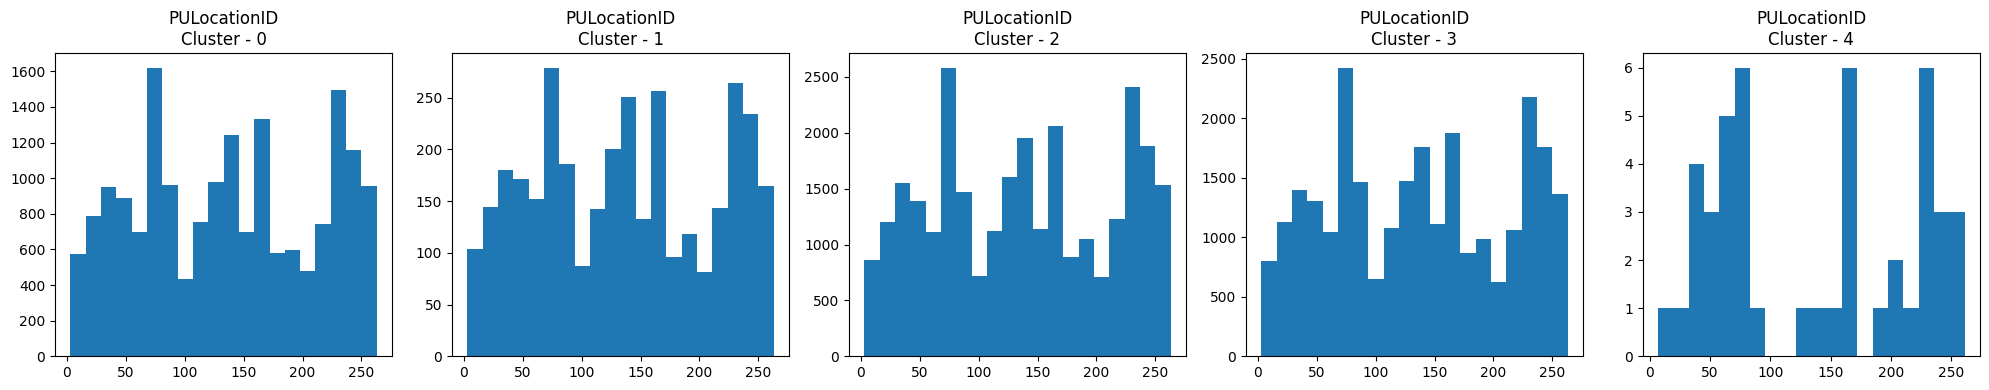

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

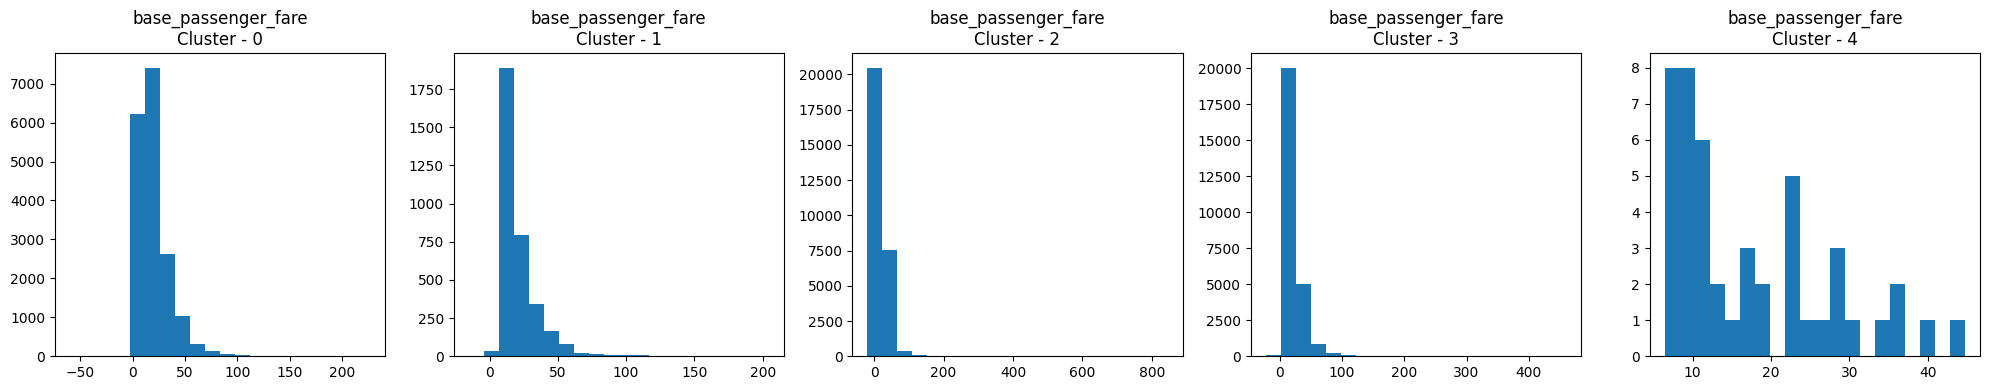

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

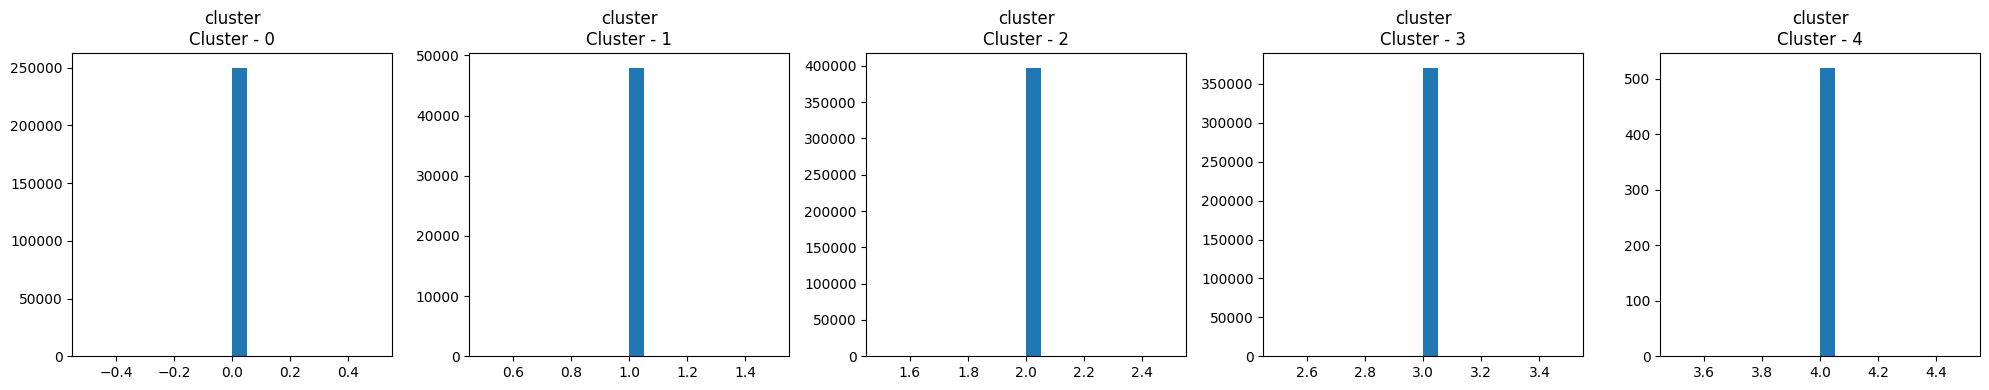

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

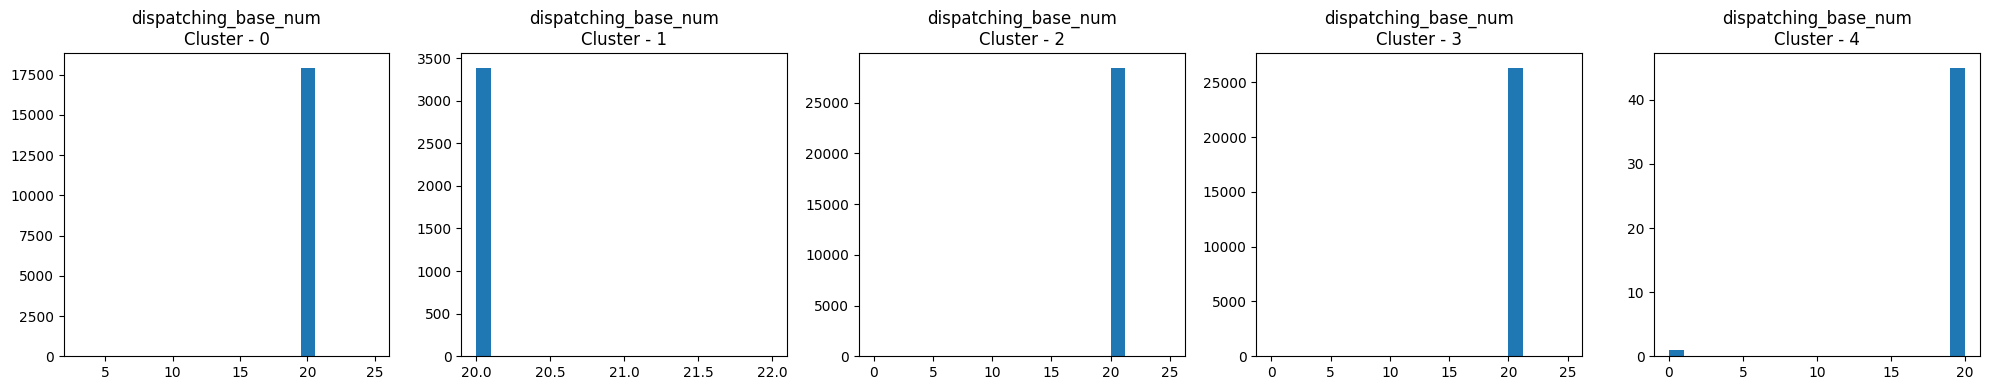

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

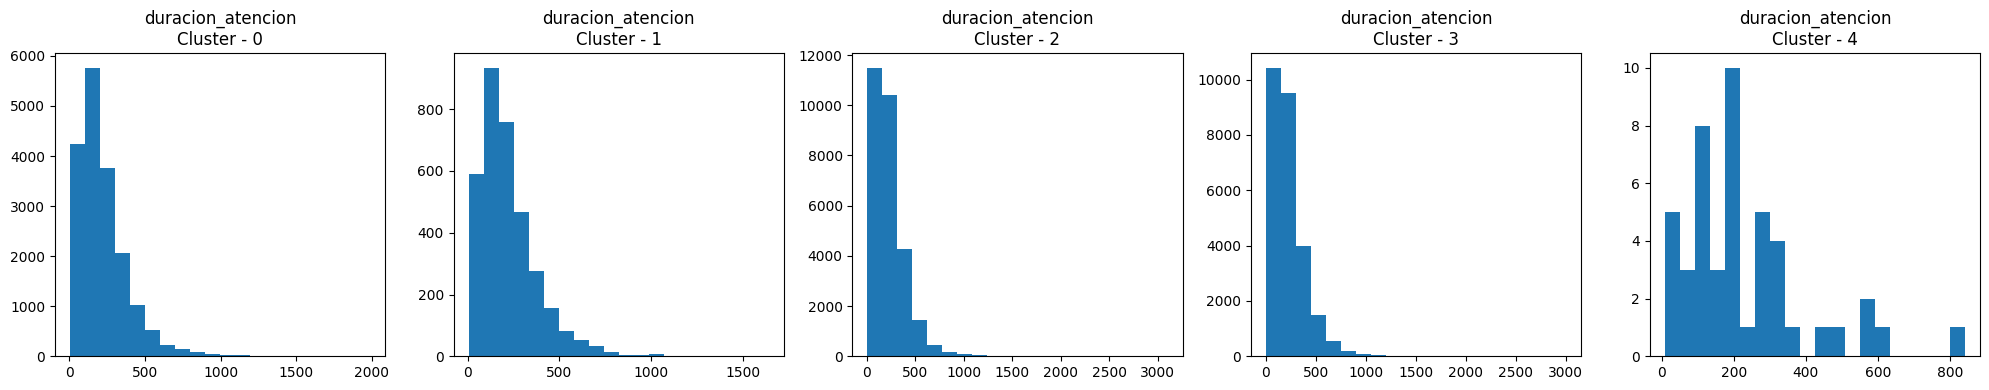

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

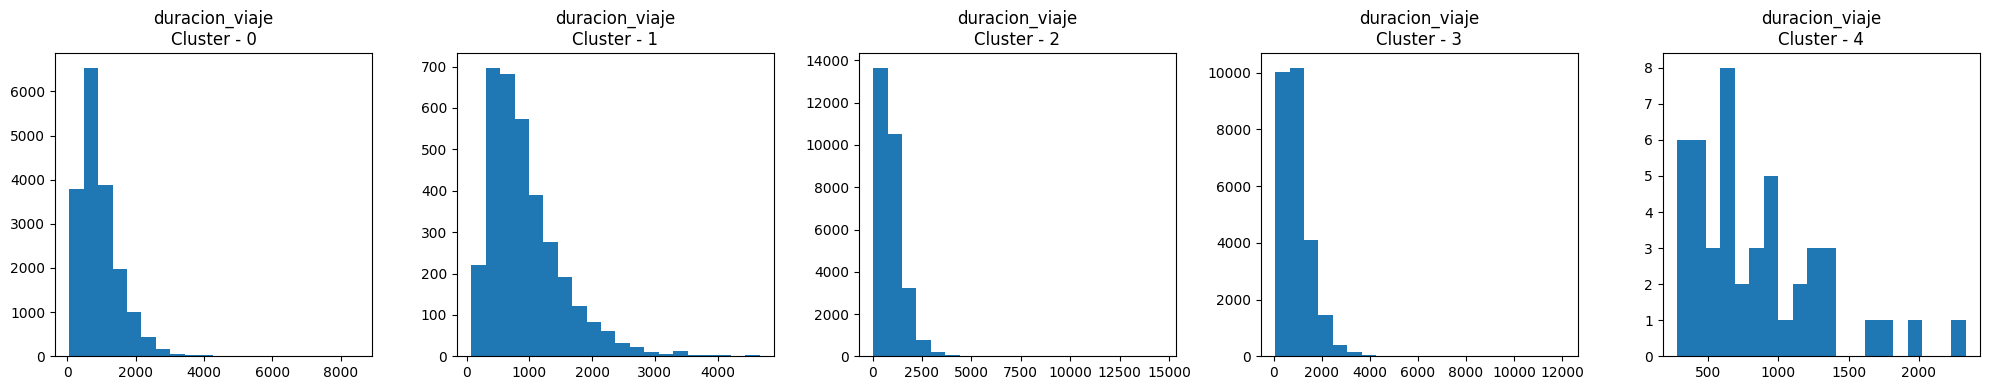

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

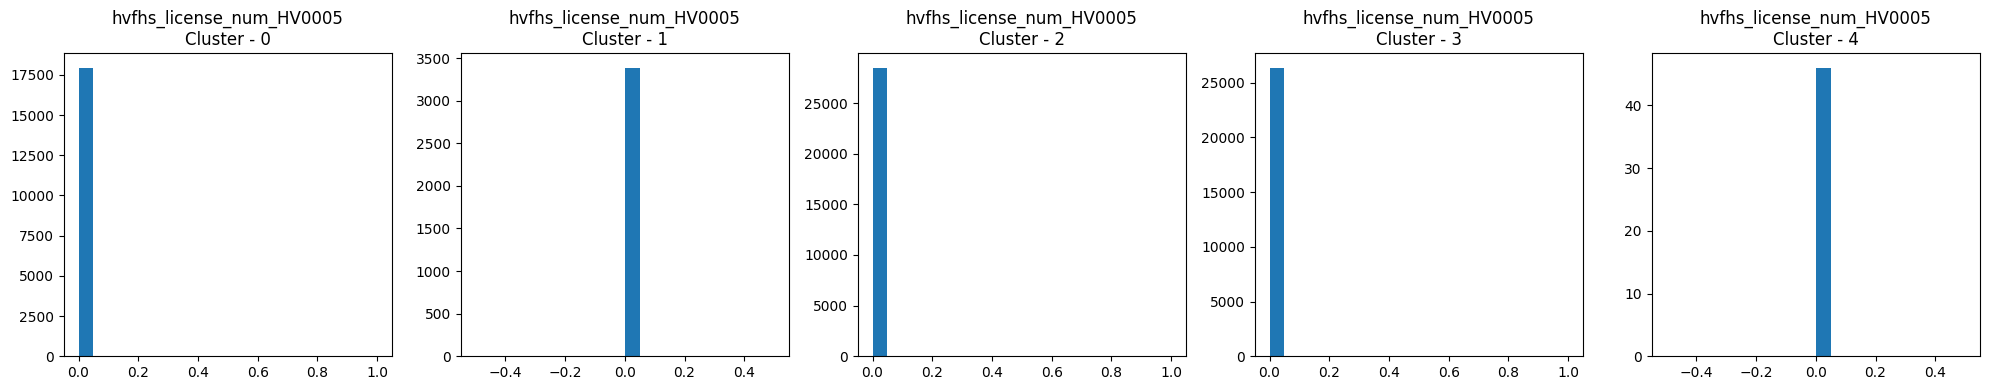

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

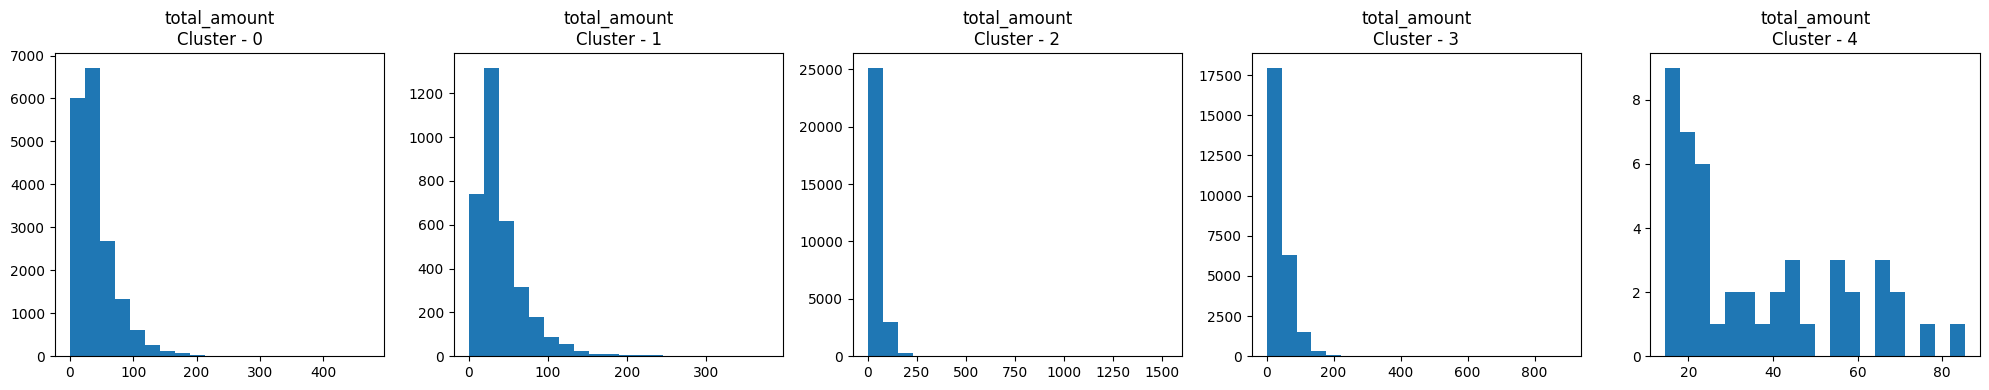

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 105.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

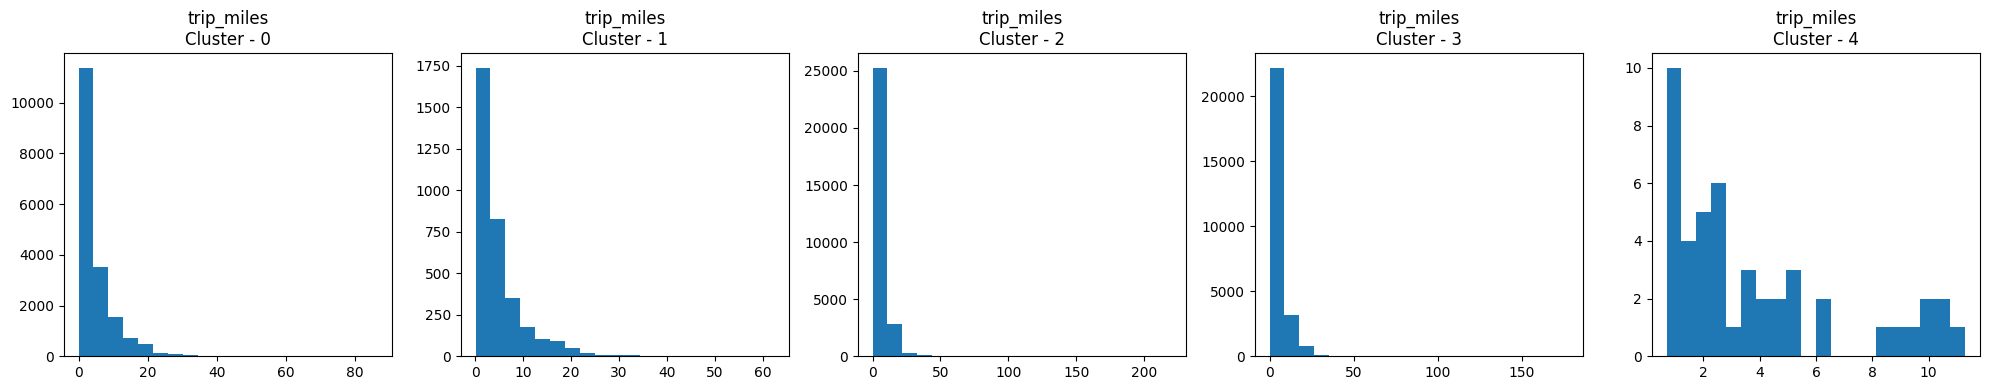

In [90]:
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np

# Convertir el arreglo de NumPy en un retraso
delayed_labels = delayed(labels)

# Crear un Dask Array desde el retraso con el número correcto de particiones
labels_dask = da.from_delayed(delayed_labels, shape=labels.shape, dtype=labels.dtype)

# Repartir ddf_resultante en 4 particiones
ddf_resultante = ddf_resultante.repartition(npartitions=4)

# Calcular el tamaño de cada partición
partition_size = np.ceil(labels_dask.shape[0] / ddf_resultante.npartitions)

# Repartir labels_dask en el mismo número de particiones que ddf_resultante
labels_dask = labels_dask.rechunk(partition_size)

# Crear un DataFrame de Dask a partir de labels_dask con el mismo número de particiones
labels_ddf = dd.from_dask_array(labels_dask, columns=['cluster'])

# Alinear labels_ddf con ddf_resultante para asegurar que tengan el mismo índice
labels_ddf, ddf_resultante = labels_ddf.align(ddf_resultante)

# Agregar la columna de clúster al DataFrame original
ddf_result_with_cluster = ddf_resultante.assign(cluster=labels_ddf['cluster'])

# Representar un histograma para cada característica según el clúster al que pertenece
for feature in ddf_resultante.columns[:10]:
    plt.figure(figsize=(20, 4))
    for cluster_id in range(5):
        plt.subplot(1, 5, cluster_id + 1)
        cluster_data = ddf_result_with_cluster[ddf_result_with_cluster['cluster'] == cluster_id][feature].compute()
        plt.hist(cluster_data, bins=20)  # Puedes ajustar el número de bins según tus preferencias
        plt.title(f'{feature}\nCluster - {cluster_id}')
    plt.tight_layout()
    plt.show()

In [50]:
ddf_resultante.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 26.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
4,20,229,141,1.65,461,9.44,461.0,16,20.75,0
7,20,151,75,2.77,843,14.41,843.0,37,31.59,0
18,20,223,179,1.69,637,9.81,637.0,261,20.52,0
19,20,179,7,0.87,472,10.53,472.0,527,21.00,0
26,20,158,261,2.25,579,13.08,579.0,385,26.04,0


In [43]:
ddf_result_with_cluster.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 20.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005,cluster
4,20,229,141,1.65,461,9.44,461.0,16,20.75,0,0
7,20,151,75,2.77,843,14.41,843.0,37,31.59,0,2
18,20,223,179,1.69,637,9.81,637.0,261,20.52,0,0
19,20,179,7,0.87,472,10.53,472.0,527,21.00,0,2
26,20,158,261,2.25,579,13.08,579.0,385,26.04,0,0


In [ ]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(result_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Definir una función para escalar cada partición del DataFrame de Dask
def scale_partition(partition):
    return scaler.fit_transform(partition)

# Aplicar la transformación de escala a cada partición del DataFrame de Dask
ddf_resultante_scaled = ddf_resultante.map_partitions(scale_partition)

# Convertir el objeto Array de nuevo a un DataFrame de Dask
ddf_resultante_scaled = dd.from_dask_array(ddf_resultante_scaled, columns=ddf_resultante.columns)

In [54]:
ddf_resultante_scaled.head()

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,duracion_viaje,duracion_atencion,total_amount,hvfhs_license_num_HV0005
0,0.018271,1.208054,-0.005513,-0.561763,-0.783537,-0.623988,-0.783631,-1.106389,-0.594083,-0.011618
1,0.018271,0.173695,-0.850330,-0.355841,-0.172387,-0.305468,-0.172270,-0.973261,-0.254151,-0.011618
2,0.018271,1.128488,0.480896,-0.554408,-0.501960,-0.600275,-0.501957,0.446769,-0.601296,-0.011618
3,0.018271,0.545003,-1.720747,-0.705172,-0.765938,-0.554132,-0.766026,2.133054,-0.586244,-0.011618
4,0.018271,0.266522,1.530517,-0.451447,-0.594752,-0.390706,-0.594781,1.232857,-0.428194,-0.011618


C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 101.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

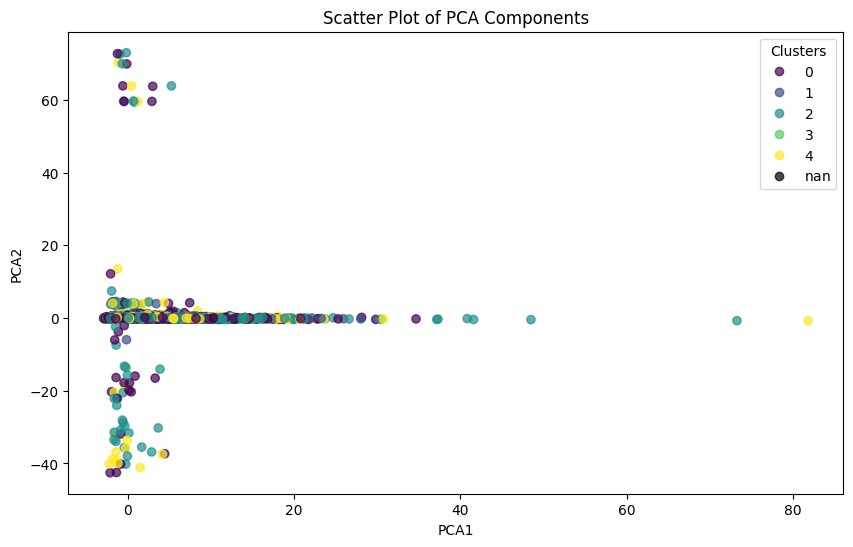

In [58]:
# Ajustar y transformar el DataFrame escalado
principal_comp = pca.fit_transform(ddf_resultante_scaled.to_dask_array(lengths=True))

# Convertir el resultado a un DataFrame de Dask
pca_ddf = dd.from_dask_array(principal_comp, columns=['pca1', 'pca2'])

# Concatenar el DataFrame de PCA con el DataFrame de etiquetas
pca_ddf['cluster'] = ddf_result_with_cluster['cluster']

# Eliminar filas con valores NaN en la columna 'cluster'
pca_ddf = pca_ddf.dropna(subset=['cluster'])

# Crear un gráfico de dispersión utilizando Matplotlib
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(
    pca_ddf['pca1'], pca_ddf['pca2'], c=pca_ddf['cluster'], cmap='viridis', alpha=0.7
)

# Agregar leyenda y etiquetas de ejes
plt.legend(*scatter_plot.legend_elements(), title='Clusters')
plt.title('Scatter Plot of PCA Components')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [63]:
pca_ddf.describe()

,pca1,pca2,cluster
npartitions=1,,,
,float64,float64,float64
,...,...,...


In [64]:
type(pca_ddf)

dask_expr._collection.DataFrame

In [66]:
# Calcular la media de pca1 por grupo
mean_pca1_by_cluster = pca_ddf.groupby('cluster')['pca1'].mean().compute()

# Calcular la desviación estándar de pca1 por grupo
std_pca1_by_cluster = pca_ddf.groupby('cluster')['pca1'].std().compute()

# Combinar los resultados en un DataFrame final
stats_by_cluster = pd.concat([mean_pca1_by_cluster.rename('mean_pca1'), std_pca1_by_cluster.rename('std_pca1')], axis=1)
stats_by_cluster

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,mean_pca1,std_pca1
cluster,,
0.0,0.000674,2.073640
1.0,-0.038779,2.137045
2.0,0.012301,2.173831
3.0,-0.392840,1.540698
4.0,-0.002517,2.121869


In [67]:
# Calcular la media de pca2 por grupo
mean_pca2_by_cluster = pca_ddf.groupby('cluster')['pca2'].mean().compute()

# Calcular la desviación estándar de pca2 por grupo
std_pca2_by_cluster = pca_ddf.groupby('cluster')['pca2'].std().compute()

# Combinar los resultados en un DataFrame final
stats_by_cluster_pca2 = pd.concat([mean_pca2_by_cluster.rename('mean_pca2'), std_pca2_by_cluster.rename('std_pca2')], axis=1)
stats_by_cluster_pca2

C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3157: UserWarning: Sending large graph of size 113.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,mean_pca2,std_pca2
cluster,,
0.0,0.004818,1.166814
1.0,0.018065,1.014768
2.0,-0.003693,1.293031
3.0,0.039945,0.116869
4.0,-0.007914,1.257567


(<dask_expr.expr.Scalar: expr=df.size() / 11, dtype=float64>, 11)

In [27]:
# 5. Cerrar el clúster de Dask
client.close()
cluster.close()